In [1]:
!pip install -Uqq librosa

In [94]:
from fastai.vision.all import *
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
path = Path('/kaggle/input/voicedata/Dataset')

In [ ]:
data = get_files(path, extensions='.wav')
data

(#1321) [Path('/kaggle/input/voicedata/Dataset/Agustin_Lopez/Agustin_Lopez_Principito_60.wav'),Path('/kaggle/input/voicedata/Dataset/Agustin_Lopez/Agustin_Lopez_Otros_18.wav'),Path('/kaggle/input/voicedata/Dataset/Agustin_Lopez/Agustin_Lopez_Principito_66.wav'),Path('/kaggle/input/voicedata/Dataset/Agustin_Lopez/Agustin_Lopez_Otros_63.wav'),Path('/kaggle/input/voicedata/Dataset/Agustin_Lopez/Agustin_Lopez_Principito_81.wav'),Path('/kaggle/input/voicedata/Dataset/Agustin_Lopez/Agustin_Lopez_Otros_16.wav'),Path('/kaggle/input/voicedata/Dataset/Agustin_Lopez/Agustin_Lopez_Principito_68.wav'),Path('/kaggle/input/voicedata/Dataset/Agustin_Lopez/Agustin_Lopez_Principito_90.wav'),Path('/kaggle/input/voicedata/Dataset/Agustin_Lopez/Agustin_Lopez_Principito_98.wav'),Path('/kaggle/input/voicedata/Dataset/Agustin_Lopez/Agustin_Lopez_Principito_34.wav')...]

In [ ]:
def plot_waveform(waveform, sr, title="Waveform", ax=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    if ax is None:
        _, ax = plt.subplots(num_channels, 1)
    ax.plot(time_axis, waveform[0], linewidth=1)
    ax.grid(True)
    ax.set_xlim([0, time_axis[-1]])
    ax.set_title(title)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")


In [ ]:
audio_test, sample_rate = torchaudio.load(data[500])
spectrogram = T.Spectrogram(n_fft=512)

n_fft = 1024
win_length = None
hop_length = 512
n_mels = 128

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    center=True,
    pad_mode="reflect",
    power=2.0,
    norm="slaney",
    n_mels=n_mels,
    mel_scale="htk",
)


/opt/conda/lib/python3.10/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(


In [ ]:
sample_rate

48000

In [ ]:
Audio(audio_test, rate=sample_rate)

In [ ]:
def show_data(waveform):
  audio, sample_rate = torchaudio.load(waveform)
  spec = mel_spectrogram(audio)
  fig, axs = plt.subplots(2, 1)
  plot_waveform(audio, sample_rate, ax=axs[0])
  plot_spectrogram(spec[0], title="spectrogram", ax=axs[1])
  fig.tight_layout()
  display(Audio(audio, rate=sample_rate))


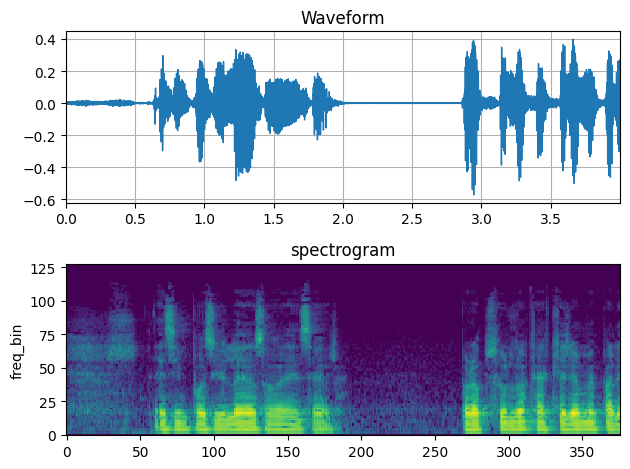

In [ ]:
show_data(data[0])

In [ ]:
# We will train using the image dataset
img_path = Path('/kaggle/input/voicerecognition/DatasetImages')


In [ ]:
#Create data block to load data into resnet18 for finetunning
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=69),
    get_y=parent_label,
).dataloaders(img_path)

dls.bs

64

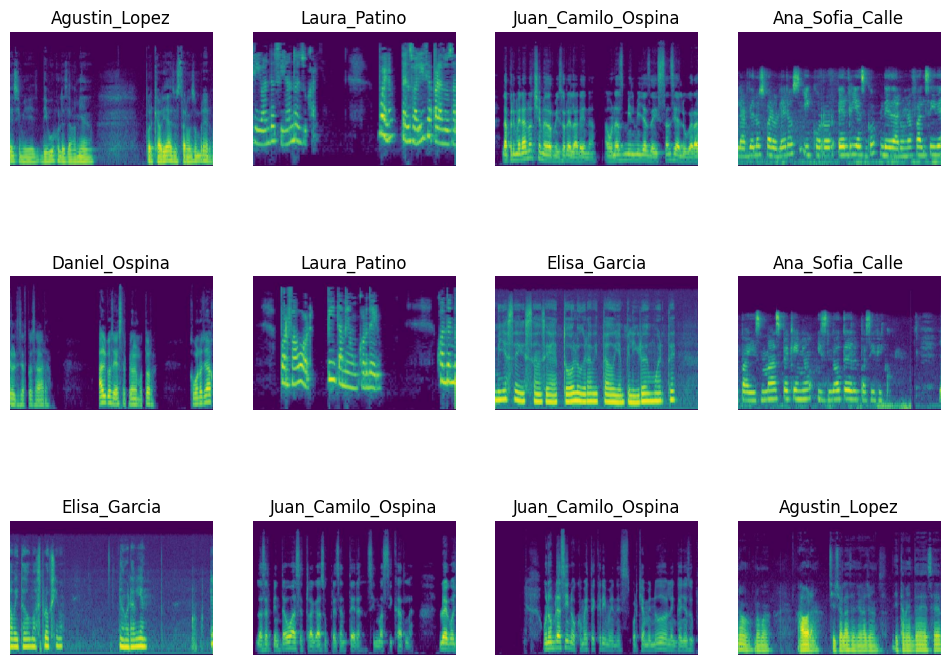

In [ ]:
dls.show_batch(max_n=12) #

In [ ]:
# Load data to learner for training
learn = vision_learner(dls, xresnet18, metrics=error_rate)

Downloading: "https://s3.amazonaws.com/fast-ai-modelzoo/xrn50_940.pth" to /root/.cache/torch/hub/checkpoints/xrn50_940.pth
100%|██████████| 244M/244M [00:09<00:00, 26.8MB/s] 


SuggestedLRs(valley=0.0014454397605732083)

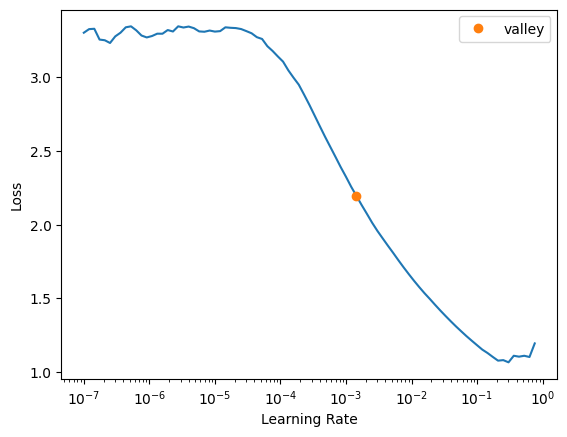

In [ ]:
#Find an optimal learning rate
learn.lr_find()

In [ ]:
learn.fine_tune(12, 2.1e-4)


epoch,train_loss,valid_loss,error_rate,time
0,2.433583,1.182790,0.435714,00:10


epoch,train_loss,valid_loss,error_rate,time
0,0.727149,0.532837,0.135714,00:14
1,0.598653,0.210864,0.057143,00:13
2,0.447293,0.117972,0.021429,00:13
3,0.342888,0.091298,0.010714,00:13
4,0.273233,0.085326,0.010714,00:13
5,0.215340,0.077788,0.007143,00:13
6,0.177153,0.072724,0.007143,00:13
7,0.144629,0.074145,0.007143,00:13
8,0.122680,0.069450,0.007143,00:13
9,0.114571,0.068594,0.007143,00:14


In [ ]:
learn.export('/kaggle/working/models/voice_classifier_v1.pkl')

In [ ]:
learn.eval()

Sequential(
  (0): Sequential(
    (0): ConvLayer(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): ConvLayer(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (2): ConvLayer(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): ResBlock(
        (convpath): Sequential(
          (0): ConvLayer(
            (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): Ba

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

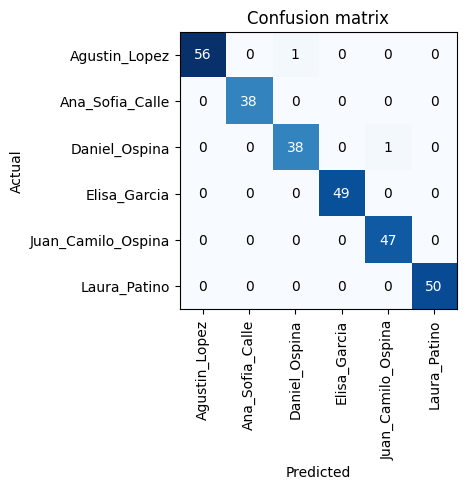

In [ ]:
interp.plot_confusion_matrix()

In [5]:
voice_classf = load_learner('/content/drive/MyDrive/VoiceRecognition/voice_classifier_v1.pkl')

## Lets Test the Model


In [82]:
test_path = '/content/drive/MyDrive/VoiceRecognition/TestImages'
person_path = '/Elisa_Garcia/Elisa_Garcia_Test_19.jpg'
person,_,probability = voice_classf.predict(PILImage.create(test_path + person_path))
print(f'This is : {person}')
print(f'Chances: {1-probability[0]:.4f}')


This is : Elisa_Garcia
Chances: 0.9999


In [60]:
test_data = get_files(test_path, extensions='.jpg')
test_data

(#453) [Path('/content/drive/MyDrive/VoiceRecognition/TestImages/Agustin_Lopez/Agustin_Lopez_Test_0.jpg'),Path('/content/drive/MyDrive/VoiceRecognition/TestImages/Agustin_Lopez/Agustin_Lopez_Test_1.jpg'),Path('/content/drive/MyDrive/VoiceRecognition/TestImages/Agustin_Lopez/Agustin_Lopez_Test_2.jpg'),Path('/content/drive/MyDrive/VoiceRecognition/TestImages/Agustin_Lopez/Agustin_Lopez_Test_3.jpg'),Path('/content/drive/MyDrive/VoiceRecognition/TestImages/Agustin_Lopez/Agustin_Lopez_Test_4.jpg'),Path('/content/drive/MyDrive/VoiceRecognition/TestImages/Agustin_Lopez/Agustin_Lopez_Test_5.jpg'),Path('/content/drive/MyDrive/VoiceRecognition/TestImages/Agustin_Lopez/Agustin_Lopez_Test_6.jpg'),Path('/content/drive/MyDrive/VoiceRecognition/TestImages/Agustin_Lopez/Agustin_Lopez_Test_7.jpg'),Path('/content/drive/MyDrive/VoiceRecognition/TestImages/Agustin_Lopez/Agustin_Lopez_Test_8.jpg'),Path('/content/drive/MyDrive/VoiceRecognition/TestImages/Agustin_Lopez/Agustin_Lopez_Test_9.jpg')...]

In [61]:
l_str = str(test_data[400]).split('/')
l_str[6]

'Laura_Patino'

In [62]:
total = len(test_data)
total

453

In [85]:
correct = 0
actual_lst = []
pred_lst = []
category = []
for test in test_data:
  actual = str(test).split('/')[6]
  pred,_,probability = voice_classf.predict(PILImage.create(test))
  if pred == actual:
    correct += 1
  actual_lst.append(actual)
  pred_lst.append(pred)
  if actual not in category: category.append(actual)



print(f'Acuracy: {(correct/total) * 100}%')



/usr/local/lib/python3.10/dist-packages/fastai/torch_core.py:263: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  return getattr(torch, 'has_mps', False)


Acuracy: 94.92273730684326%


In [88]:
category

['Agustin_Lopez',
 'Ana_Sofia_Calle',
 'Daniel_Ospina',
 'Elisa_Garcia',
 'Juan_Camilo_Ospina',
 'Laura_Patino']

In [93]:
conf_mat = confusion_matrix(actual_lst, pred_lst, labels=category)
conf_mat

array([[75,  0,  0,  0,  0,  0],
       [ 0, 74,  0,  0,  0,  0],
       [ 0,  0, 53,  0, 22,  0],
       [ 0,  0,  0, 76,  0,  0],
       [ 0,  0,  1,  0, 74,  0],
       [ 0,  0,  0,  0,  0, 78]])

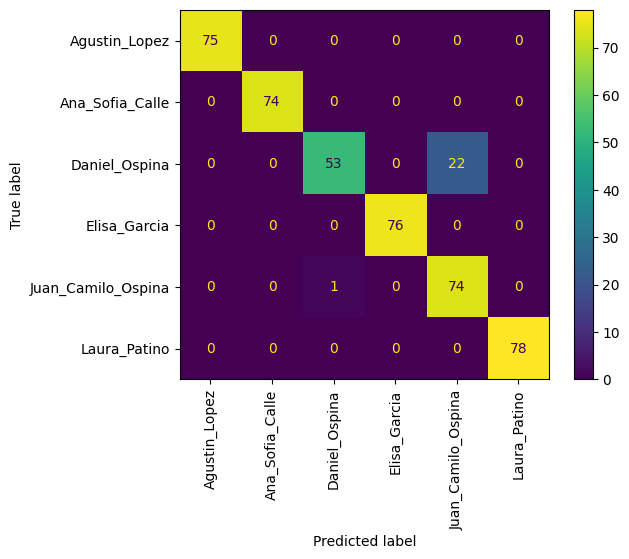

In [106]:
disp = ConfusionMatrixDisplay(conf_mat, display_labels=category)
disp.plot(xticks_rotation='vertical', cmap='viridis')
plt.show()